In [ ]:
# Ch16-2 Protein Design with LLMs

In [ ]:
# Install packages 
! pip install torch transformers numpy

In [ ]:
# 11.  Import Libraries


✅ All packages imported successfully!
🔧 PyTorch version: 2.0.1
💻 CUDA available: False
🚀 Initializing ProtGPT2 Designer...
🔄 Loading ProtGPT2 model and tokenizer...
🖥️  Using device: cpu
✅ Model loaded successfully!
📊 Model parameters: 774,030,080
✅ Ready to generate proteins!

🧪 EXAMPLE 1: De novo protein generation
🧬 Generating 3 protein sequence(s)...

🧬 Generated Protein 1:
Sequence: MEVRMNTYIYALFVLALLSPAYAQETTAAPADNTTTAAPATTTAAPANTTAAPANTTAAP
ANTTAAPANTTAAPANTTA...
📏 Length: 300 amino acids
✅ Validity: 1.000
🔬 Valid: Yes
💧 Hydrophobic: 0.567
⚡ Charged: 0.013

🧬 Generated Protein 2:
Sequence: MTMEQIMRVMDTMSREEQEAYLRSVAARKAAAAARAAAERAAAAAAAQRAAAAAAAQRAA
AAAAAQRAAAAAAAAAARA...
📏 Length: 296 amino acids
✅ Validity: 1.000
🔬 Valid: Yes
💧 Hydrophobic: 0.764
⚡ Charged: 0.057

🧬 Generated Protein 3:
Sequence: MKKITLLLLTTIAFSFASYAQTATPVVSKTVDGATYTTTVSTNTYNSTVTINGVKFTATT
GNVTISANGDITINPTATG...
📏 Length: 103 amino acids
✅ Validity: 1.000
🔬 Valid: Yes
💧 Hydrophobic: 0.379
⚡ Charged: 0.068

🎯 E

Generating proteins:   0%|          | 0/20 [00:00<?, ?it/s]


📈 Generated 20 proteins
✅ Valid proteins: 20
📏 Average length: 345.8 ± 181.6
🎯 Validity ratio: 1.000 ± 0.000

📊 Summary Statistics:
           length  validity_ratio  hydrophobic_content  charged_content  \
count   20.000000            20.0            20.000000        20.000000   
mean   345.800000             1.0             0.338504         0.147171   
std    181.612543             0.0             0.207078         0.167409   
min     72.000000             1.0             0.009766         0.000000   
25%    258.500000             1.0             0.216557         0.013504   
50%    376.500000             1.0             0.357911         0.085878   
75%    417.000000             1.0             0.428004         0.228253   
max    898.000000             1.0             0.772414         0.552699   

       polar_content  aromatic_content  
count      20.000000         20.000000  
mean        0.279123          0.061040  
std         0.157838          0.097172  
min         0.003341       

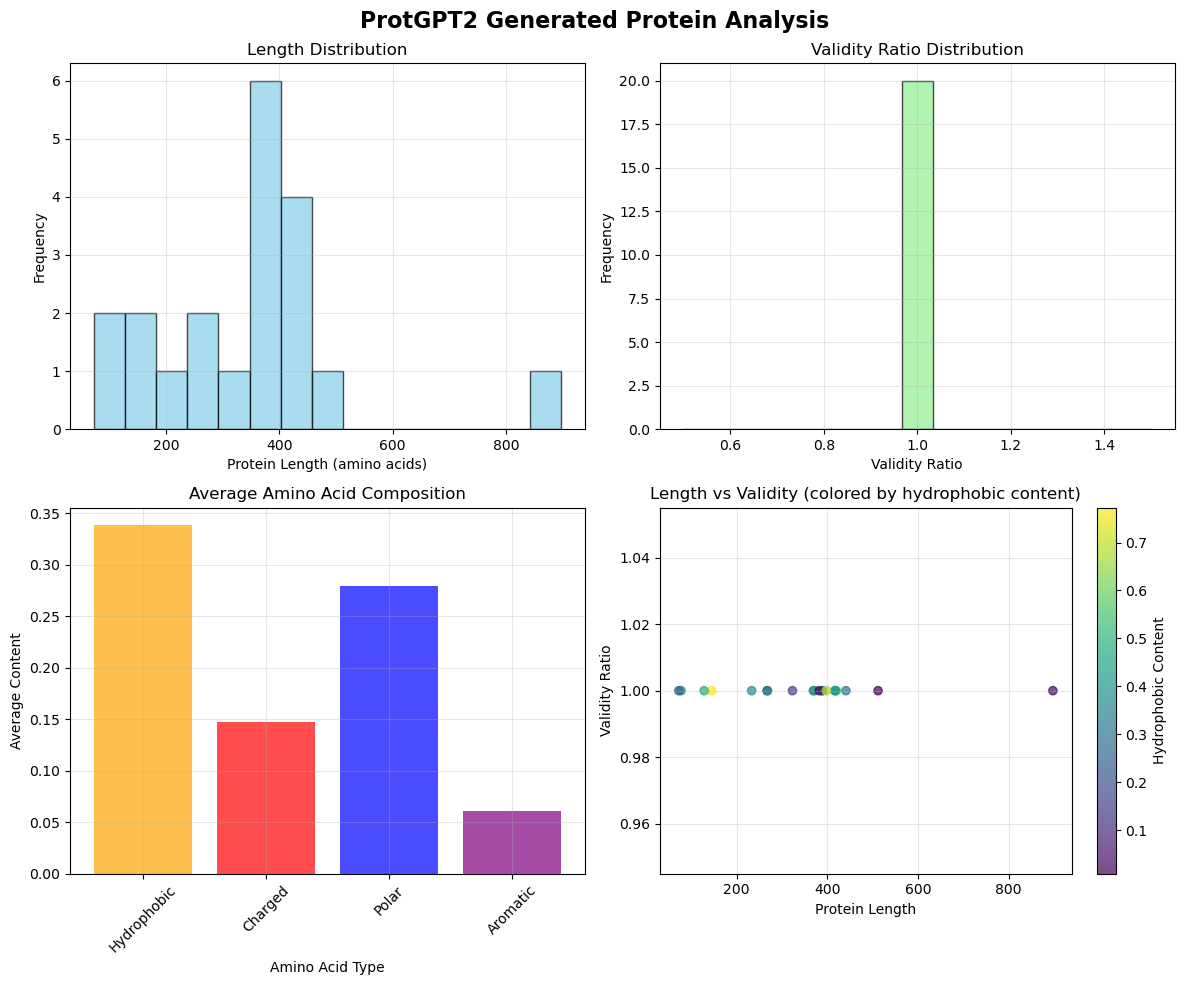


🧬 Sample Generated Sequences:

PROTEIN_001:
Sequence: MMPPPAAASAAAAAVAAAAAAGTGTAGAAAAAAGGGEAEAGGGGGGGGGGGAAGGGGGGGGGGGGDGGGGGGGGDGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
Length: 898 | Validity: 1.000 | Hydrophobic: 0

In [9]:
# ProtGPT2 Protein Design - Jupyter Notebook
# =============================================
# This notebook demonstrates how to use ProtGPT2 to generate novel protein sequences

# Cell 1: Installation (run this first)
# =====================================
"""
Run this cell first to install required packages:
"""
# Uncomment and run the following line if packages aren't installed:
# !pip install torch transformers numpy matplotlib seaborn pandas

# Cell 2: Imports and Setup
# =========================
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional
import warnings
from tqdm.auto import tqdm
import logging
import os
import sys

# COMPREHENSIVE WARNING SUPPRESSION
# =================================
# Set environment variable to suppress transformers warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'

# Monkey patch the logging warning function to prevent specific padding warnings
original_warning = warnings.warn
def patched_warning(message, category=UserWarning, filename='', lineno=-1, file=None, line=None):
    # Block specific padding warnings
    if isinstance(message, str):
        if any(phrase in message.lower() for phrase in [
            'right-padding', 'padding_side', 'decoder-only', 
            'correct generation results', 'left when initializing'
        ]):
            return  # Don't show these warnings
    # Show other warnings normally
    original_warning(message, category, filename, lineno, file, line)

# Apply the patch
warnings.warn = patched_warning

# Additional comprehensive warning filters
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
for logger_name in ['transformers', 'transformers.generation_utils', 'transformers.tokenization_utils']:
    logging.getLogger(logger_name).setLevel(logging.ERROR)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All packages imported successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"💻 CUDA available: {torch.cuda.is_available()}")

# Cell 3: ProtGPT2 Designer Class
# ===============================
class ProtGPT2Designer:
    """A wrapper class for protein design using ProtGPT2."""
    
    def __init__(self, model_name: str = "nferruz/ProtGPT2"):
        """
        Initialize the ProtGPT2 model and tokenizer.
        
        Args:
            model_name: HuggingFace model identifier for ProtGPT2
        """
        print("🔄 Loading ProtGPT2 model and tokenizer...")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🖥️  Using device: {self.device}")
        
        # Load model first
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
        
        # Load tokenizer with explicit configuration
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        
        # Configure tokenizer for decoder-only architecture
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.tokenizer.padding_side = 'left'
        
        # Configure model to match tokenizer
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.generation_config.pad_token_id = self.tokenizer.pad_token_id
        self.model.generation_config.eos_token_id = self.tokenizer.eos_token_id
        
        print("✅ Model loaded successfully!")
        print(f"📊 Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
    
    def generate_protein(self, 
                        prompt: str = "<|endoftext|>",
                        max_length: int = 200,
                        temperature: float = 1.0,
                        num_sequences: int = 1,
                        do_sample: bool = True,
                        top_p: float = 0.9,
                        show_progress: bool = True) -> List[str]:
        """
        Generate protein sequences using ProtGPT2 (warning-free method).
        
        Args:
            prompt: Starting sequence or prompt (use "<|endoftext|>" for de novo generation)
            max_length: Maximum length of generated sequence
            temperature: Sampling temperature (higher = more random)
            num_sequences: Number of sequences to generate
            do_sample: Whether to use sampling (vs greedy decoding)
            top_p: Top-p sampling parameter
            show_progress: Whether to show progress bar
            
        Returns:
            List of generated protein sequences
        """
        if show_progress:
            print(f"🧬 Generating {num_sequences} protein sequence(s)...")
        
        sequences = []
        
        # Context manager to completely suppress output during generation
        class SuppressOutput:
            def __enter__(self):
                self._original_stdout = sys.stdout
                self._original_stderr = sys.stderr
                sys.stdout = open(os.devnull, 'w')
                sys.stderr = open(os.devnull, 'w')
                return self
            
            def __exit__(self, exc_type, exc_val, exc_tb):
                sys.stdout.close()
                sys.stderr.close()
                sys.stdout = self._original_stdout
                sys.stderr = self._original_stderr
        
        try:
            for i in range(num_sequences):
                # Tokenize input
                input_ids = torch.tensor([self.tokenizer.encode(prompt)], device=self.device)
                
                # Generate with complete output suppression
                with SuppressOutput():
                    with torch.no_grad():
                        output = self.model.generate(
                            input_ids,
                            max_length=max_length,
                            temperature=temperature,
                            num_return_sequences=1,
                            do_sample=do_sample,
                            top_p=top_p,
                            pad_token_id=self.tokenizer.pad_token_id,
                            eos_token_id=self.tokenizer.eos_token_id
                        )
                
                # Decode the generated sequence
                sequence = self.tokenizer.decode(output[0], skip_special_tokens=True)
                
                # Clean up the sequence
                if prompt != "<|endoftext|>" and sequence.startswith(prompt):
                    sequence = sequence[len(prompt):]
                
                sequences.append(sequence.strip())
                
        except Exception as e:
            if show_progress:
                print(f"❌ Error in generation: {e}")
                print("🔄 Trying fallback method...")
            
            # Fallback to manual token generation
            sequences = self._generate_manual_fallback(prompt, max_length, temperature, num_sequences)
        
        return sequences
    
    def _generate_manual_fallback(self, 
                                 prompt: str,
                                 max_length: int,
                                 temperature: float,
                                 num_sequences: int) -> List[str]:
        """
        Fallback generation method using manual token-by-token generation.
        """
        sequences = []
        
        for _ in range(num_sequences):
            # Start with the prompt
            current_text = prompt
            
            # Manual token-by-token generation
            for _ in range(max_length):
                # Encode current sequence
                input_ids = torch.tensor([self.tokenizer.encode(current_text)], device=self.device)
                
                with torch.no_grad():
                    # Get logits for next token
                    outputs = self.model(input_ids)
                    logits = outputs.logits[0, -1, :]  # Last token logits
                    
                    # Apply temperature
                    if temperature != 1.0:
                        logits = logits / temperature
                    
                    # Sample next token
                    probs = torch.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, 1).item()
                    
                    # Check for end of sequence
                    if next_token == self.tokenizer.eos_token_id:
                        break
                    
                    # Add token to sequence
                    next_char = self.tokenizer.decode([next_token])
                    current_text += next_char
            
            # Clean up the sequence
            if prompt != "<|endoftext|>" and current_text.startswith(prompt):
                sequence = current_text[len(prompt):]
            else:
                sequence = current_text.replace("<|endoftext|>", "")
            
            sequences.append(sequence.strip())
        
        return sequences
    
    def validate_sequence(self, sequence: str) -> dict:
        """
        Basic validation of a protein sequence.
        
        Args:
            sequence: Protein sequence to validate
            
        Returns:
            Dictionary with validation results
        """
        # Standard amino acids
        standard_aa = set('ACDEFGHIKLMNPQRSTVWY')
        
        # Clean sequence (remove whitespace and convert to uppercase)
        clean_seq = re.sub(r'\s+', '', sequence.upper())
        
        # Calculate statistics
        length = len(clean_seq)
        valid_aa = sum(1 for aa in clean_seq if aa in standard_aa)
        invalid_aa = length - valid_aa
        validity_ratio = valid_aa / length if length > 0 else 0
        
        # Calculate amino acid composition
        aa_counts = {aa: clean_seq.count(aa) for aa in standard_aa}
        aa_frequencies = {aa: count/length for aa, count in aa_counts.items() if length > 0}
        
        # Calculate some basic properties
        hydrophobic_aa = set('AILMFPWV')
        polar_aa = set('NQST')
        charged_aa = set('DEKR')
        aromatic_aa = set('FWY')
        
        hydrophobic_content = sum(aa_frequencies.get(aa, 0) for aa in hydrophobic_aa)
        polar_content = sum(aa_frequencies.get(aa, 0) for aa in polar_aa)
        charged_content = sum(aa_frequencies.get(aa, 0) for aa in charged_aa)
        aromatic_content = sum(aa_frequencies.get(aa, 0) for aa in aromatic_aa)
        
        return {
            'sequence': clean_seq,
            'length': length,
            'valid_amino_acids': valid_aa,
            'invalid_amino_acids': invalid_aa,
            'validity_ratio': validity_ratio,
            'is_valid': validity_ratio > 0.95,
            'amino_acid_composition': aa_frequencies,
            'hydrophobic_content': hydrophobic_content,
            'polar_content': polar_content,
            'charged_content': charged_content,
            'aromatic_content': aromatic_content
        }
    
    def batch_generate_and_validate(self, 
                                   num_proteins: int = 10,
                                   target_length: int = 150,
                                   temperature: float = 0.8) -> pd.DataFrame:
        """
        Generate multiple proteins and return validation results as DataFrame.
        
        Args:
            num_proteins: Number of proteins to generate
            target_length: Target length for proteins
            temperature: Sampling temperature
            
        Returns:
            DataFrame with protein sequences and validation metrics
        """
        results = []
        
        print(f"🔬 Generating and validating {num_proteins} proteins...")
        
        for i in tqdm(range(num_proteins), desc="Generating proteins"):
            sequences = self.generate_protein(
                max_length=target_length + 50,
                temperature=temperature,
                num_sequences=1,
                show_progress=False
            )
            
            # Ensure sequences is not None and is iterable
            if sequences is None:
                print(f"⚠️ Warning: No sequences generated for protein {i+1}")
                continue
                
            for seq in sequences:
                if seq:  # Make sure sequence is not empty
                    validation = self.validate_sequence(seq)
                    validation['protein_id'] = f"protein_{i+1:03d}"
                    results.append(validation)
        
        if not results:
            print("❌ No valid proteins were generated!")
            return pd.DataFrame()
            
        df = pd.DataFrame(results)
        return df

# Cell 4: Initialize the Model
# ============================
print("🚀 Initializing ProtGPT2 Designer...")
print("=" * 50)

designer = ProtGPT2Designer()

print("✅ Ready to generate proteins!")
print()

# Cell 5: Example 1 - De Novo Protein Generation
# ==============================================
print("🧪 EXAMPLE 1: De novo protein generation")
print("=" * 50)

# Generate some proteins from scratch
sequences = designer.generate_protein(
    prompt="<|endoftext|>",
    max_length=100,
    temperature=0.8,
    num_sequences=3
)

# Display results
for i, seq in enumerate(sequences, 1):
    print(f"\n🧬 Generated Protein {i}:")
    print(f"Sequence: {seq[:80]}{'...' if len(seq) > 80 else ''}")
    
    # Validate the sequence
    validation = designer.validate_sequence(seq)
    print(f"📏 Length: {validation['length']} amino acids")
    print(f"✅ Validity: {validation['validity_ratio']:.3f}")
    print(f"🔬 Valid: {'Yes' if validation['is_valid'] else 'No'}")
    print(f"💧 Hydrophobic: {validation['hydrophobic_content']:.3f}")
    print(f"⚡ Charged: {validation['charged_content']:.3f}")

# Cell 6: Example 2 - Motif-Based Generation
# ==========================================
print("\n🎯 EXAMPLE 2: Protein generation with starting motif")
print("=" * 50)

# Generate proteins starting with a signal peptide-like motif
motif = "MKKLLF"
motif_sequences = designer.generate_protein(
    prompt=motif,
    max_length=120,
    temperature=0.7,
    num_sequences=2
)

for i, seq in enumerate(motif_sequences, 1):
    full_sequence = motif + seq
    print(f"\n🧬 Motif-based Protein {i}:")
    print(f"Sequence: {full_sequence[:80]}{'...' if len(full_sequence) > 80 else ''}")
    validation = designer.validate_sequence(full_sequence)
    print(f"📏 Length: {validation['length']} amino acids")
    print(f"✅ Validity: {validation['validity_ratio']:.3f}")

# Cell 7: Batch Generation and Analysis
# =====================================
print("\n📊 EXAMPLE 3: Batch generation and analysis")
print("=" * 50)

# Generate multiple proteins for statistical analysis
df_proteins = designer.batch_generate_and_validate(
    num_proteins=20,
    target_length=100,
    temperature=0.8
)

print(f"\n📈 Generated {len(df_proteins)} proteins")
print(f"✅ Valid proteins: {df_proteins['is_valid'].sum()}")
print(f"📏 Average length: {df_proteins['length'].mean():.1f} ± {df_proteins['length'].std():.1f}")
print(f"🎯 Validity ratio: {df_proteins['validity_ratio'].mean():.3f} ± {df_proteins['validity_ratio'].std():.3f}")

# Display summary statistics
print("\n📊 Summary Statistics:")
print(df_proteins[['length', 'validity_ratio', 'hydrophobic_content', 
                   'charged_content', 'polar_content', 'aromatic_content']].describe())

# Cell 8: Visualization
# ====================
print("\n📈 Creating visualizations...")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('ProtGPT2 Generated Protein Analysis', fontsize=16, fontweight='bold')

# Length distribution
axes[0,0].hist(df_proteins['length'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Protein Length (amino acids)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Length Distribution')
axes[0,0].grid(True, alpha=0.3)

# Validity ratio distribution
axes[0,1].hist(df_proteins['validity_ratio'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_xlabel('Validity Ratio')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Validity Ratio Distribution')
axes[0,1].grid(True, alpha=0.3)

# Amino acid composition comparison
composition_data = df_proteins[['hydrophobic_content', 'charged_content', 
                               'polar_content', 'aromatic_content']]
composition_means = composition_data.mean()
axes[1,0].bar(range(len(composition_means)), composition_means.values, 
              color=['orange', 'red', 'blue', 'purple'], alpha=0.7)
axes[1,0].set_xlabel('Amino Acid Type')
axes[1,0].set_ylabel('Average Content')
axes[1,0].set_title('Average Amino Acid Composition')
axes[1,0].set_xticks(range(len(composition_means)))
axes[1,0].set_xticklabels(['Hydrophobic', 'Charged', 'Polar', 'Aromatic'], rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Length vs validity scatter plot
scatter = axes[1,1].scatter(df_proteins['length'], df_proteins['validity_ratio'], 
                           c=df_proteins['hydrophobic_content'], cmap='viridis', alpha=0.7)
axes[1,1].set_xlabel('Protein Length')
axes[1,1].set_ylabel('Validity Ratio')
axes[1,1].set_title('Length vs Validity (colored by hydrophobic content)')
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,1], label='Hydrophobic Content')

plt.tight_layout()
plt.show()

# Cell 9: Display Sample Sequences
# ================================
print("\n🧬 Sample Generated Sequences:")
print("=" * 50)

# Show a few complete sequences
valid_proteins = df_proteins[df_proteins['is_valid'] == True].head(5)

for idx, row in valid_proteins.iterrows():
    print(f"\n{row['protein_id'].upper()}:")
    print(f"Sequence: {row['sequence']}")
    print(f"Length: {row['length']} | Validity: {row['validity_ratio']:.3f} | "
          f"Hydrophobic: {row['hydrophobic_content']:.3f}")

# Cell 10: Temperature Comparison
# ===============================
print("\n⚡ ADVANCED EXAMPLE: Temperature comparison")
print("=" * 50)

# Compare different temperatures
temperatures = [0.5, 0.8, 1.2]
temp_results = {}

for temp in temperatures:
    print(f"\n🌡️  Temperature: {temp}")
    seqs = designer.generate_protein(
        max_length=80,
        temperature=temp,
        num_sequences=2,
        show_progress=False
    )
    
    temp_results[temp] = seqs
    for i, seq in enumerate(seqs, 1):
        validation = designer.validate_sequence(seq)
        print(f"  Seq {i}: {seq[:50]}{'...' if len(seq) > 50 else ''} "
              f"(L={validation['length']}, V={validation['validity_ratio']:.2f})")

print("\n🎉 Analysis complete! You can now:")
print("   • Modify generation parameters in any cell")
print("   • Generate more proteins with different settings")
print("   • Analyze specific protein properties")
print("   • Export sequences for further analysis")

# Optional: Save results
# df_proteins.to_csv('generated_proteins.csv', index=False)
# print("💾 Results saved to 'generated_proteins.csv'")